# Intercomparison of rotation rate estimates -- IceFloeTracker.jl

1. quadDIRECT wrapper. Currently implemented in the IFT via the `mismatch` function. Issues with rotation rates higher than 67 degrees between images. Some unexpected behavior with test cases. Rather slow.
2. Comparison of the "orientation" property estimate from the regionprops table.
3. Difference in mean psi-s curves
4. Minimization of the shape difference 

## Function definitions


In [1]:
using Pkg
Pkg.activate("../scripts/calval")

using IceFloeTracker
using Plots
using Images
using Interpolations
using Statistics

# Simple convenience function to carry out a rotation
# using linear interpolation, turn it to an array, and
# fill NaN's with 0's.
imrotate_linear_nocrop(x, r) = replace(
            collect(
            imrotate(x, deg2rad(r), method=BSpline(Linear()
                )
            )
        ), NaN => 0)


# Functions used for the SD minimization
"""
Pad images by zeros based on the size of the larger of the two images.
"""
function pad_images(im1, im2)
    max1 = maximum(size(im1))
    max2 = maximum(size(im2))
    
    n = Int64(ceil(maximum([max1, max2])))
    im1_padded = collect(padarray(im1, Fill(0, (n, n), (n, n))))
    im2_padded = collect(padarray(im2, Fill(0, (n, n), (n, n))))
    return im1_padded, im2_padded
end

"""
Calculate the centroid of a binary image. If 'rounded', return the
nearest integer. Indices are weighted by the pixel values. The image
needs to either be binary or be grayscale.
"""
function compute_centroid(im; rounded=false)
    xi = 0
    yi = 0
    R = sum(im)
    n, m = size(im)
    for ii in range(1, n)
        for jj in range(1, m)
            if im[ii, jj] > 0
                xi += ii*im[ii,jj]
                yi += jj*im[ii,jj]
            end
        end
    end
    
    x0, y0 = sum(xi)/R, sum(yi)/R

    if rounded
        return round(Int32, x0), round(Int32, y0)
    else
        return x0, y0
    end
end

"""
Align images by selecting and cropping so that r1, c1 and r2, c2 are the center.
These values are expected to be the (integer) centroid of the image. These images
should already be padded so that there is no danger of cutting into the floe shape.
"""
function crop_to_shared_centroid(im1, im2)
    r1, c1 = compute_centroid(im1, rounded=true)
    r2, c2 = compute_centroid(im2, rounded=true)
    
    n1, m1 = size(im1)
    n2, m2 = size(im2)
    new_halfn = minimum([minimum([r1, n1-r1]), minimum([r2, n2-r2])])
    new_halfm = minimum([minimum([c1, m1-c1]), minimum([c2, m2-c2])])

    # check notation: how does julia interpret start and end of array index?
    im1_cropped = im1[1+r1-new_halfn:r1 + new_halfn, 1 + c1-new_halfm:c1 + new_halfm]
    im2_cropped = im2[1+r2-new_halfn:r2 + new_halfn, 1 + c2-new_halfm:c2 + new_halfm]

    return im1_cropped, im2_cropped    
end

"""
Computes the shape difference between im_reference and im_target for each angle (degrees) in test_angles.
The reference image is held constant, while the target image is rotated. The test_angles are interpreted
as the angle of rotation from target to reference, so to find the best match, we rotate the reverse
direction. A perfect match at angle A would imply im_target is the same shape as if im_reference was 
rotated by A degrees. This function assumes the input images are padded, but that could be brought into the function.
"""
function shape_difference_rotation(im_reference, im_target, test_angles)
    imref_padded, imtarget_padded = pad_images(im_reference, im_target)
    shape_differences = zeros(size(test_angles))

    idx = 1
    for angle in test_angles
        imtarget_rotated = imrotate_linear_nocrop(imtarget_padded, -angle)
        im1, im2 = crop_to_shared_centroid(imref_padded, imtarget_rotated)
        shape_differences[idx] = sum(abs.(im1 .- im2))
        idx += 1
    end
    return shape_differences
end

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/calval`


shape_difference_rotation

In [23]:
# Load the images from file
test_images_loc = "../data/test_images_tracker_setup/"

# Function to convert image to mask
greaterthan05(x) = x .> 0.5 

# Add labels and get region properties
# labeled_image = label_components(image);
# props = regionprops_table(labeled_image);
props = []
labeled_images = []
for fname in ["001-baffin_bay-20220911-aqua-labeled_floes.png",
              "021_baffin_bay_20120422_aqua_labeled_floes_v1.png",
              "022-barents_kara_seas-20060909-aqua-labeled_floes.png",
              "036_baffin_bay_20210602_aqua_labeled_floes_v1.png",
              "065-bering_chukchi_seas-20080507-aqua-labeled_floes.png",
              "148-laptev_sea-20110324-aqua-labeled_floes.png",]
    image = load(joinpath(test_images_loc, fname))
        
    # Add labels and get region properties
    labeled_image = label_components(image)
    push!(labeled_images, labeled_image)
    props_table = regionprops_table(labeled_image)
    props_table = copy(props_table[props_table.area .> 25,:])
    IceFloeTracker.addfloemasks!(props_table, greaterthan05.(labeled_image))
    push!(props, props_table)        
    # append!(props, IceFloeTracker.addfloemasks!(props_table, greaterthan0.(labeled_image)))
end
all_props = reduce(vcat, props)
# gotta be a better way to do this -- can't tell why 
# addψs!(props) wouldn't work but this next line does
IceFloeTracker.addψs!([all_props]);

In [16]:
function rotation_test(props_df, angles)
    # initialize dataframe to store data
    df = DataFrame(
        floe_id=Int16[],               
        area_init=Float64[],
        area_rotated=Float64[],               
        major_axis_length_init=Float64[],
        major_axis_length_rotated=Float64[],           
        minor_axis_length_init=Float64[],
        minor_axis_length_rotated=Float64[],
        true_rotation=Float64[],
        orientation_init=Float64[],
        orientation_rotated=Float64[],
        psi_s_mean_init=Float64[],
        psi_s_mean_rotated=Float64[],
        psi_s_corr=Float64[], # correlation between rotated shape and init
        psi_n=Int16[], # length of psi-s curve -- maybe useful for psi-s confidence interval
        qd_rotation=Float64[], # rotation estimate from the quadDIRECT algorithm
        qd_mismatch=Float64[], # shape mismatch parameter from quadDIRECT
        sd_rotation=Float64[], # rotation estimate from the shape difference minimization
        sd_mismatch=Float64[] # shape difference after rotation
        )
    
    floe_id = 0
    for floe_data in eachrow(props_df)
        floe_id += 1
        if floe_data["area"] > 100
            for rotation in angles
                init_floe = copy(floe_data["mask"])
                
                # rotate floe and get the floe properties table set up
                rotated_floe = greaterthan05(imrotate_linear_nocrop(init_floe, rotation))
                rotated_props = regionprops_table(label_components(rotated_floe))
                IceFloeTracker.addfloemasks!(rotated_props, rotated_floe) # needed for psi s

                # filter out singletons
                rotated_props = rotated_props[rotated_props.area .> 1, :]

                # Adding the psi-s curve sometimes fails!
                IceFloeTracker.addψs!([rotated_props])
                rotated_props = rotated_props[1, :]
                pcorr = IceFloeTracker.corr(floe_data["psi"], rotated_props["psi"])
                n_psi = size(floe_data["psi"])[1]
                p1_mean = mean(floe_data["psi"])
                p2_mean = mean(rotated_props["psi"])

                qd_mismatch, qd_rotation = IceFloeTracker.mismatch(init_floe, rotated_floe)
    
                # First sweep steps of 10
                test_angles = range(-180, 170, step=10)
                sd = shape_difference_rotation(init_floe, rotated_floe, test_angles)
                first_min = test_angles[argmin(sd)]

                # Narrow search to 30 degree window, stepsize 0.5 
                test_angles = range(floor(first_min - 15), ceil(first_min + 15), step = 0.25)
                sd = shape_difference_rotation(init_floe, rotated_floe, test_angles)
                sd_rotation = test_angles[argmin(sd)]
                sd_mismatch = minimum(sd)
                
                test_results = 
                        (
                        floe_id,               
                        floe_data["area"],
                        rotated_props["area"],
                        round(floe_data["major_axis_length"], sigdigits=3),
                        round(rotated_props["major_axis_length"], sigdigits=3),
                        round(floe_data["minor_axis_length"], sigdigits=3),
                        round(rotated_props["minor_axis_length"], sigdigits=3),
                        rotation,
                        round(floe_data["orientation"], sigdigits=3),
                        round(rotated_props["orientation"], sigdigits=3),
                        round(p1_mean, sigdigits=3),
                        round(p2_mean, sigdigits=3),
                        round(pcorr, sigdigits=3),
                        n_psi,
                        round(qd_rotation, sigdigits=3), # rotation estimate from the quadDIRECT algorithm
                        round(qd_mismatch, sigdigits=3), # shape mismatch parameter from quadDIRECT
                        sd_rotation, # rotation estimate from the shape difference minimization
                        round(sd_mismatch, sigdigits=3) # shape difference after rotation
                        )
                push!(df, test_results)
            end
        end
    end
return df
end

rotation_test (generic function with 1 method)

In [25]:
@time begin
    df = rotation_test(all_props, LinRange(-70, 90, 20));
end

484.512329 seconds (78.95 M allocations: 947.595 GiB, 7.22% gc time, 0.18% compilation time: 94% of which was recompilation)


Row,floe_id,area_init,area_rotated,major_axis_length_init,major_axis_length_rotated,minor_axis_length_init,minor_axis_length_rotated,true_rotation,orientation_init,orientation_rotated,psi_s_mean_init,psi_s_mean_rotated,psi_s_corr,psi_n,qd_rotation,qd_mismatch,sd_rotation,sd_mismatch
,Int16,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int16,Float64,Float64,Float64,Float64
1,1,612.0,600.0,35.1,34.4,22.3,22.3,-70.0,0.709,-1.22,8.37,7.67,0.997,40,67.5,0.0134,-67.5,62.3
2,1,612.0,602.0,35.1,34.5,22.3,22.4,-61.5789,0.709,-1.36,8.37,7.88,0.993,40,60.7,0.013,-61.75,29.9
3,1,612.0,602.0,35.1,34.6,22.3,22.2,-53.1579,0.709,-1.51,8.37,7.67,0.991,40,52.3,0.0115,-51.75,31.9
4,1,612.0,597.0,35.1,34.5,22.3,22.2,-44.7368,0.709,1.48,8.37,7.85,0.986,40,43.7,0.0125,-42.25,58.7
5,1,612.0,599.0,35.1,34.5,22.3,22.2,-36.3158,0.709,1.33,8.37,8.42,0.993,40,36.0,0.0097,-36.25,29.0
6,1,612.0,601.0,35.1,34.4,22.3,22.3,-27.8947,0.709,1.19,8.37,8.47,0.999,40,27.2,0.0114,-27.0,31.6
7,1,612.0,605.0,35.1,34.4,22.3,22.5,-19.4737,0.709,1.02,8.37,8.49,1.0,40,18.7,0.0113,-18.25,31.6
8,1,612.0,602.0,35.1,34.5,22.3,22.3,-11.0526,0.709,0.884,8.37,8.56,1.0,40,10.1,0.00934,-14.0,41.2
9,1,612.0,603.0,35.1,34.5,22.3,22.3,-2.63158,0.709,0.761,8.37,8.44,1.0,40,2.62,0.00992,0.0,19.0


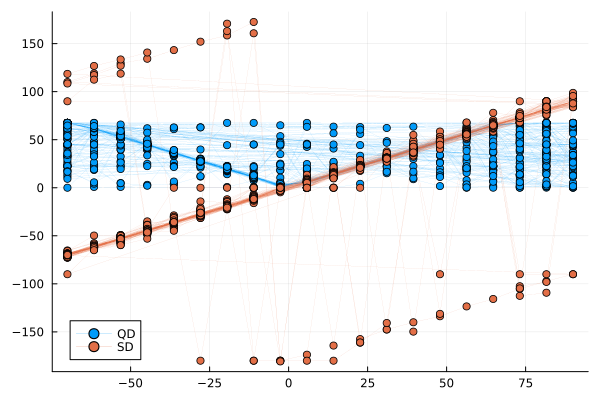

In [26]:
plot(df[!, :true_rotation], df[!, :qd_rotation], lw=0, m=:circle, label="QD")
plot!(df[!, :true_rotation], df[!, :sd_rotation], lw=0, m=:circle, label="SD")

In [27]:
using CSV
CSV.write("../data/rotation_comparison_test.csv", df);

,,

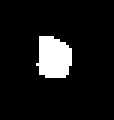
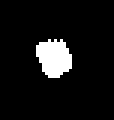
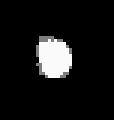

In [124]:
init_floe = all_props[81,:mask]
ang = 30
im_rotated = imrotate_bin(init_floe, -ang)
im_reference, im_rotated = pad_images(init_floe, im_rotated)
init_props = regionprops_table(label_components(im_reference))[1,:] # assumption only one object in image!
rotated_props = regionprops_table(label_components(im_rotated))[1,:]
im1, im2 = crop_to_shared_centroid(im_reference, im_rotated)
IceFloeTracker.imshow.([im1.*255, im2.*255, (im1 .+ im2) .* 125])

In [78]:
n, m = size(im2)
print([n, m, n/2, m/2])

[38.0, 48.0, 19.0, 24.0]

In [79]:
rotated_props[["row_centroid", "col_centroid"]]

Row,row_centroid,col_centroid
,Int64,Int64
1,20,24


In [ ]:
7	92.0 	1
8 	73.0 	1
13 	85.0 	1
15 	67.0 	1
22 	65.0 	1

In [118]:
for i in range(1, size(all_props)[1])
    if isequal(all_props[i, :area], 135)
        print(i)
    end
end

81

## Test

Area: 135.0

,,

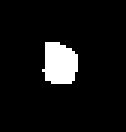
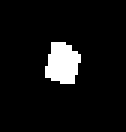
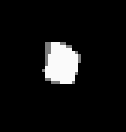

In [119]:
init_floe = all_props[81,:mask]
print("Area: ", all_props[81, :area])
r_angle = 10
rotated_floe = imrotate_bin_nocrop(init_floe, r_angle)
im1_pad, im2_pad = pad_images(init_floe, rotated_floe)
im1_pad, im2_pad = crop_to_shared_centroid(im1_pad, im2_pad)
IceFloeTracker.imshow.([im1_pad.*255, im2_pad.*255, (im1_pad .+ im2_pad) .* 125])

True rotation = 10

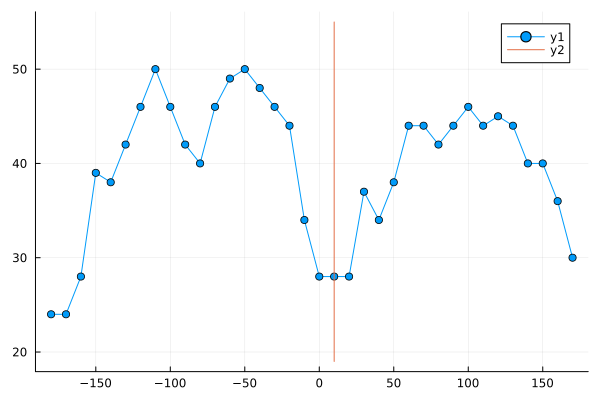

In [120]:
test_angles = range(-180, 170, step=10)
sd = shape_difference_rotation(init_floe, rotated_floe, test_angles)
first_min = test_angles[argmin(sd)]
print("True rotation = ", r_angle)
plot(test_angles, sd, m=:circle)
plot!([r_angle, r_angle], [minimum(sd)-5, maximum(sd)+5])

Figuring out the cause of the spike in SD

In [369]:
floe_id = 1
angle = -50
im_reference = all_props[floe_id, :mask]
im_rotated = imrotate_bin_nocrop(im_reference, angle)

init_padded, init_rotated = pad_images(im_reference, im_rotated)
IceFloeTracker.imshow.([init_padded .* 255, init_rotated .* 255])

im_rotated = imrotate_bin(init_rotated, -angle)
rotated_props = regionprops_table(label_components(im_rotated))
init_props = regionprops_table(label_components(init_padded))[1,:]

print(size(rotated_props))
rotated_props = rotated_props[1,:]
im1, im2 = crop_to_shared_centroid(init_padded,
                                   im_rotated,
                                   init_props.row_centroid,
                                   rotated_props.row_centroid,
                                   init_props.col_centroid,
                                   rotated_props.col_centroid)

a_not_b = im1 .> 0 .&& isequal.(im2, 0)
b_not_a = im2 .> 0 .&& isequal.(im1, 0)
sum(a_not_b .|| b_not_a), sd[2]

(1, 12)

(18, 320.0)

,,

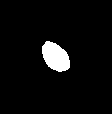
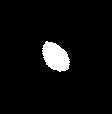
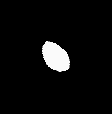

In [370]:
IceFloeTracker.imshow.([im1.*255, im2.*255, (im1 .+ im2).*125])

In [351]:
im1, im2 = crop_to_shared_centroid(im_reference,
                                   im_rotated,
                                   init_props.row_centroid,
                                   rotated_props.row_centroid,
                                   init_props.col_centroid,
                                   rotated_props.col_centroid)
sum(im1 .> 0)

612

In [355]:
init_props[["row_centroid", "col_centroid"]]

Row,row_centroid,col_centroid
,Int64,Int64
1,58,56


In [356]:
compute_centroid(im_reference)

(58.49183006535948, 56.245098039215684)